<a href="https://colab.research.google.com/github/lucasguo086/GNN_sample_code/blob/main/GNN%E8%B7%86%E6%8B%B3%E9%81%93%E4%BF%B1%E4%B9%90%E9%83%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)

1.12.1+cu113


In [2]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

In [13]:
from pyparsing import with_attribute
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G,color):
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  nx.draw_networkx(G,pos=nx.spring_layout(G,seed=42),with_labels=False,node_color=color,cmap="Set2")
  plt.show()

def visualize_embedding(h,color,epoch=None,loss=None):
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  h = h.detach().cpu().numpy()
  plt.scatter(h[:,0],h[:,1],s=140,c=color,cmap='Set2')
  if epoch is not None and loss is not None:
    plt.xlabel(f'Epoch:{epoch},loss:{loss.item():.4f}',fontsize=16)
  plt.show()

In [4]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print(f'Dataset:{dataset}:')
print(f'Number of features: {dataset.num_features}')
print(f'Number of graphs:{len(dataset)}')
print(f'Number of classes:{dataset.num_classes}')

Dataset:KarateClub():
Number of features: 34
Number of graphs:1
Number of classes:4


In [11]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


[34, 34]代表34个点, 每个点有34个特征
[2,156]表示有156个边

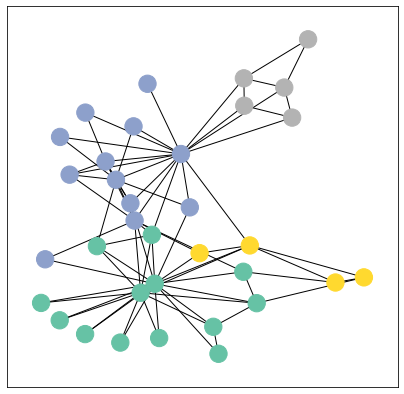

In [14]:
from torch_geometric.utils import to_networkx
G = to_networkx(data,to_undirected=True)
visualize_graph(G, color=data.y)

定义网络结构

In [17]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(1234)
    self.conv1 = GCNConv(dataset.num_features,4) #输入是34纬向量, 经过这一层后每个点变成4维向量
    self.conv2 = GCNConv(4,4) # 输入是4, 输出是4
    self.conv3 = GCNConv(4,2) # 输入是4, 输出是2,目的是后面做2纬可视化
    self.classifier = Linear(2,dataset.num_classes) # 全连接, 2维向量来预测4个类别

  def forward(self,x,edge_index): #邻接矩阵 
    h = self.conv1(x,edge_index) #x是图, 包含了每个点的特征, edge_index是邻接矩阵
    h = h.tanh()
    h = self.conv2(h,edge_index)
    h = h.tanh()
    h = self.conv3(h,edge_index)
    h = h.tanh()
    out = self.classifier(h)
    return out,h

model = GCN()
print(model)



GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape:[34, 2]


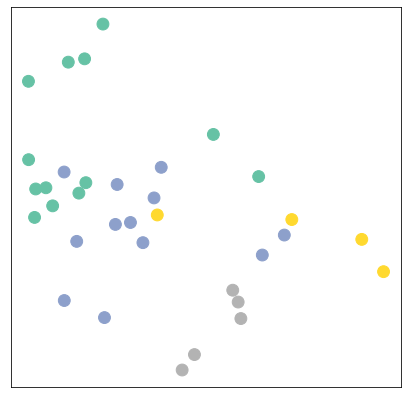

In [18]:
model = GCN()
_,h = model(data.x,data.edge_index)
print(f'Embedding shape:{list(h.shape)}')
visualize_embedding(h,color=data.y) #现在看到的随机初始化点模型, 还没有经过训练

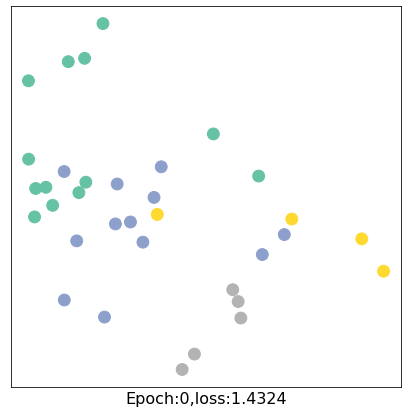

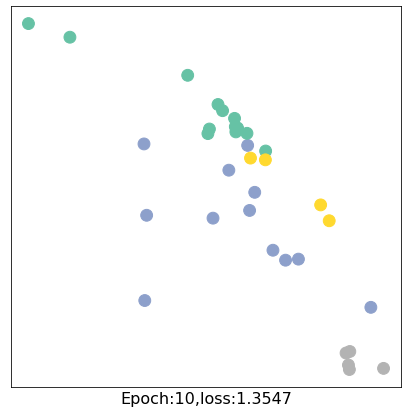

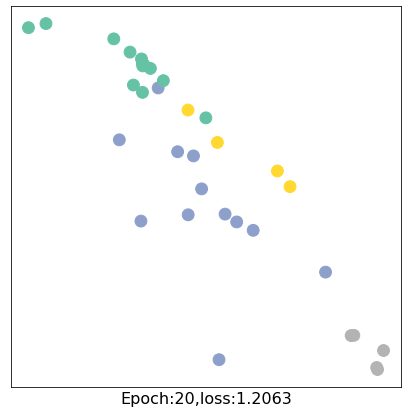

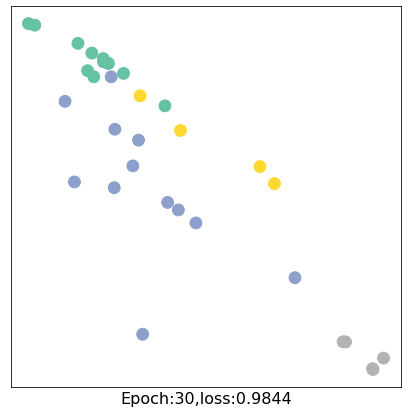

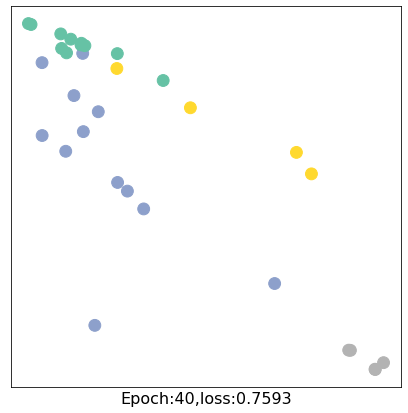

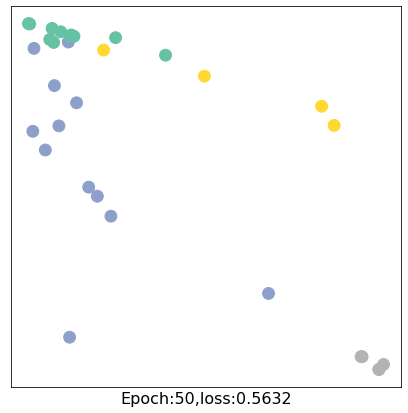

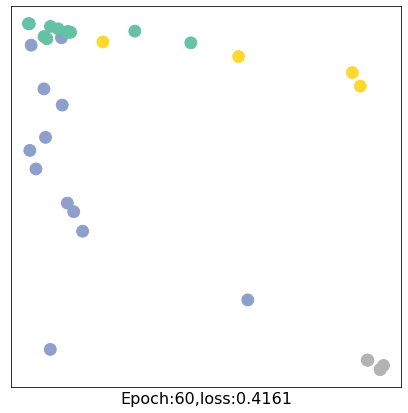

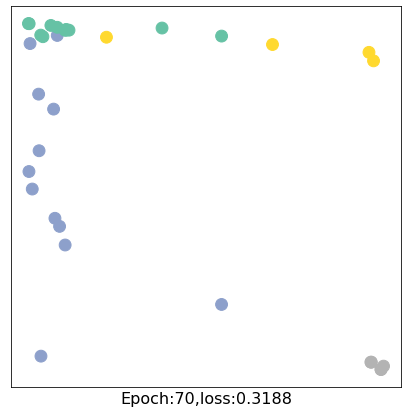

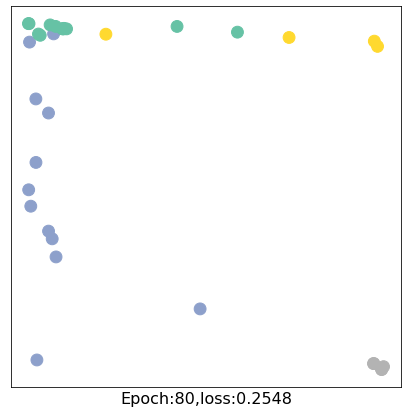

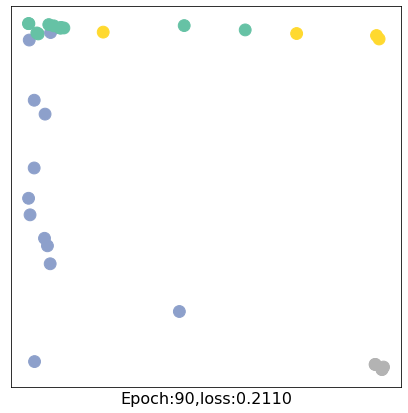

In [21]:
import time
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

def train(data):
  optimizer.zero_grad()
  out,h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask],data.y[data.train_mask]) #只关注有标签的那些 其他的结果对于损失没有影响
  loss.backward()
  optimizer.step()
  return loss,h

for epoch in range(100):
  loss,h = train(data)
  if epoch % 10 == 0:
    visualize_embedding(h,color=data.y, epoch=epoch, loss=loss)
    time.sleep(0.3)